# SIAMESE NETWORK

In [97]:
#------------------------------------------------------------------------------------------------

## IMPORITNG PACKAGES

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

## LET'S GET THE DATASET

In [276]:
!wget https://github.com/maticvl/dataHacker/raw/master/DATA/at%26t.zip
!rm -rf data
!unzip 'at&t.zip.2'

--2023-04-21 15:37:11--  https://github.com/maticvl/dataHacker/raw/master/DATA/at%26t.zip
Resolving github.com (github.com)... 20.207.73.82
Connecting to github.com (github.com)|20.207.73.82|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/maticvl/dataHacker/master/DATA/at%26t.zip [following]
--2023-04-21 15:37:11--  https://raw.githubusercontent.com/maticvl/dataHacker/master/DATA/at%26t.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3797060 (3.6M) [application/zip]
Saving to: ‘at&t.zip.4’

at&t.zip.4          100%[===================>]   3.62M  2.64MB/s    in 1.4s    

2023-04-21 15:37:13 (2.64 MB/s) - ‘at&t.zip.4’ saved [3797060/3797060]

Archive:  at&t.zip.2
   creating: data/
   creatin

In [14]:
!unzip 'at&t.zip.2'

Archive:  at&t.zip.2
   creating: data/
   creating: data/faces/
   creating: data/faces/testing/
   creating: data/faces/testing/s5/
  inflating: data/faces/testing/s5/1.pgm  
  inflating: data/faces/testing/s5/10.pgm  
  inflating: data/faces/testing/s5/2.pgm  
  inflating: data/faces/testing/s5/3.pgm  
  inflating: data/faces/testing/s5/4.pgm  
  inflating: data/faces/testing/s5/5.pgm  
  inflating: data/faces/testing/s5/6.pgm  
  inflating: data/faces/testing/s5/7.pgm  
  inflating: data/faces/testing/s5/8.pgm  
  inflating: data/faces/testing/s5/9.pgm  
   creating: data/faces/testing/s6/
  inflating: data/faces/testing/s6/1.pgm  
  inflating: data/faces/testing/s6/10.pgm  
  inflating: data/faces/testing/s6/2.pgm  
  inflating: data/faces/testing/s6/3.pgm  
  inflating: data/faces/testing/s6/4.pgm  
  inflating: data/faces/testing/s6/5.pgm  
  inflating: data/faces/testing/s6/6.pgm  
  inflating: data/faces/testing/s6/7.pgm  
  inflating: data/faces/testing/s6/8.pgm  
  inflating

# FUNCTIONS FOR PLOTTING IMAGES & LOSS

In [3]:
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text,fontweight='bold',
            bbox={'facecolor':'lightgreen', 'alpha':1, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

# CUSTOM DATASET CLASS

In [4]:
class SiameseNetworkDataset(Dataset):
    def __init__(self,imageFolderDataset,transform=None):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:
            while True:
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] != img1_tuple[1]:
                    break
        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])],dtype=np.float32))
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

# LOADING DATASET

In [5]:
folder_dataset = datasets.ImageFolder(root="./data/faces/training/")
transformation = transforms.Compose([transforms.Resize((100,100)),transforms.ToTensor()])
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,transform=transformation)

# OUR NETWORK

In [6]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11,stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(256, 384, kernel_size=3,stride=1),
            nn.ReLU())
        
        self.fc1 = nn.Sequential(
            nn.Linear(384, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256,2)
        )
        
    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2


# DEFINE LOSS FUNCTIONS

In [9]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
    def forward(self, output1, output2, label):
      eucd = F.pairwise_distance(output1, output2, keepdim = True)
      loss_contrastive = torch.mean((1-label) * torch.pow(eucd, 2) +(label) * torch.pow(torch.clamp(self.margin - eucd, min=0.0), 2))
      return loss_contrastive

# SETTING THINGS

In [12]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=64)

net = SiameseNetwork()
closs = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0005 )

# TRAINING

Epoch number 0
 Current loss 2.4311187267303467

Epoch number 1
 Current loss 0.6059417128562927

Epoch number 2
 Current loss 0.5409896373748779

Epoch number 3
 Current loss 0.659988522529602

Epoch number 4
 Current loss 0.3974289298057556

Epoch number 5
 Current loss 0.42814308404922485

Epoch number 6
 Current loss 0.3794932961463928

Epoch number 7
 Current loss 0.5989092588424683

Epoch number 8
 Current loss 0.4774407744407654

Epoch number 9
 Current loss 0.5060133337974548

Epoch number 10
 Current loss 0.48025983572006226

Epoch number 11
 Current loss 0.41214632987976074

Epoch number 12
 Current loss 0.3723026216030121

Epoch number 13
 Current loss 0.37297865748405457

Epoch number 14
 Current loss 0.6542948484420776

Epoch number 15
 Current loss 0.44602954387664795

Epoch number 16
 Current loss 0.40870219469070435

Epoch number 17
 Current loss 0.46274709701538086

Epoch number 18
 Current loss 0.5660912990570068

Epoch number 19
 Current loss 0.2197599858045578



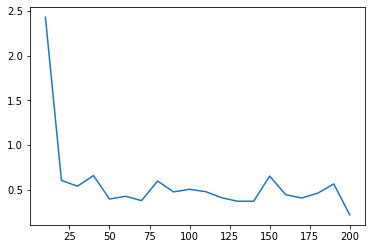

In [13]:
counter = []
closs = ContrastiveLoss
loss_history = [] 
iteration_number= 0
for epoch in range(20):
    for i, (img0, img1, label) in enumerate(train_dataloader, 0):
        optimizer.zero_grad()
        output1, output2 = net(img0, img1)
        loss = closs()(output1, output2, label)
        loss.backward()
        optimizer.step()
        if i % 10 == 0 :
            print(f"Epoch number {epoch}\n Current loss {loss.item()}\n")
            iteration_number += 10
            counter.append(iteration_number)
            loss_history.append(loss.item())
show_plot(counter, loss_history)

# TESTING THE MODEL

0 1


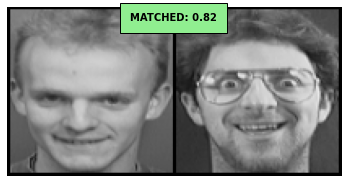

1 1


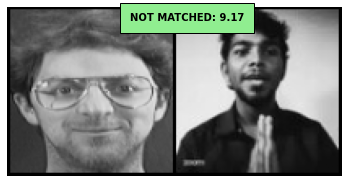

1 1


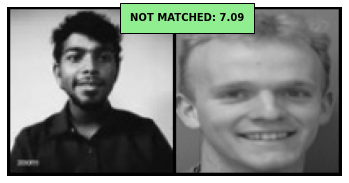

1 1


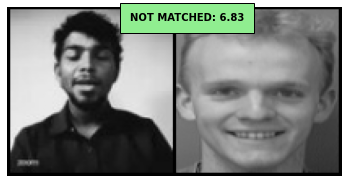

0 0


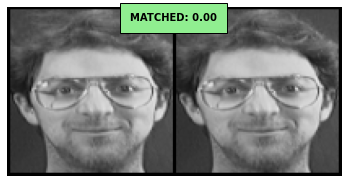

0 0


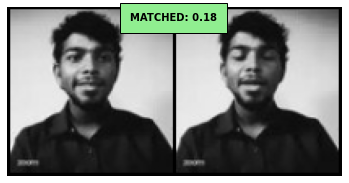

0 0


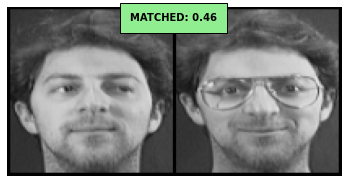

0 0


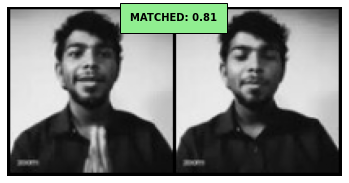

1 1


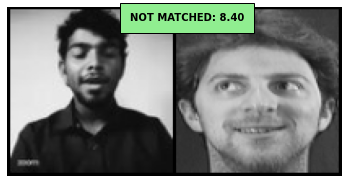

0 1


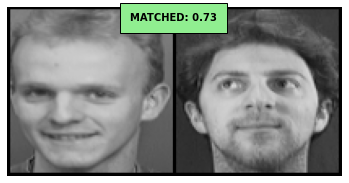

1 1


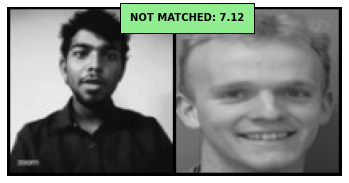

0 1


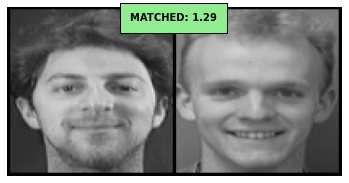

0 0


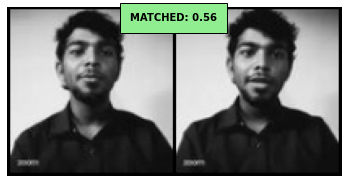

1 1


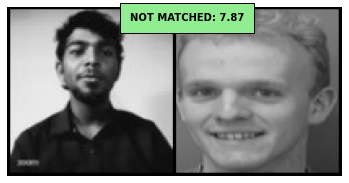

0 1


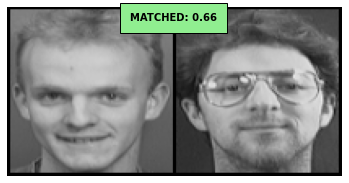

Accuracy: 0.73


In [14]:
folder_dataset_test = datasets.ImageFolder(root="./data/faces/testing/")
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transformation)
test_dataloader = DataLoader(siamese_dataset, num_workers=2, batch_size=1, shuffle=True)
dataiter = iter(test_dataloader)

correct = 0
total = 15
for i in range(total):
    found = -1
    x0, x1, label2 = next(dataiter)
    concatenated = torch.cat((x0, x1), 0)    
    output1, output2 = net(x0, x1)
    euclidean_distance = F.pairwise_distance(output1, output2)
    if euclidean_distance.item()<3:
        string = 'MATCHED'
        found = 0
    else:
        string = 'NOT MATCHED'
        found = 1
    if(found==int(label2)):
        correct+=1
    print(found,int(label2))
    imshow(torchvision.utils.make_grid(concatenated), f'{string}: {euclidean_distance.item():.2f}')
print(f'Accuracy: {round(correct/total, 2)}')